In [1]:
import os
import shutil
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

2023-11-27 00:35:42.635630: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-27 00:35:42.639354: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-27 00:35:42.681861: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-27 00:35:42.681898: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-27 00:35:42.682998: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

In [2]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

from tensorflow.keras.preprocessing.image import img_to_array, load_img
from PIL import Image

In [ ]:
#Data train-validation split

In [2]:
# # Original dataset directory
# original_dataset_dir = 'drinking_waste'

# # Base directory for the new dataset (will be created)
# base_dir = 'trash_images/waste_detection1'
# os.makedirs(base_dir, exist_ok=True)

# # Directories for training and validation splits
# train_dir = os.path.join(base_dir, 'train')
# validation_dir = os.path.join(base_dir, 'validation')
# os.makedirs(train_dir, exist_ok=True)
# os.makedirs(validation_dir, exist_ok=True)

# # Percentage of data to be used for validation
# validation_size = 0.2

In [3]:
# # List of categories/classes
# categories = ['AluCan', 'Glass', 'HDPEM', 'PET']

# for category in categories:
#     # Directory with our category pictures
#     category_dir = os.path.join(original_dataset_dir, category)

#     # Create directories for each category inside train and validation directories
#     os.makedirs(os.path.join(train_dir, category), exist_ok=True)
#     os.makedirs(os.path.join(validation_dir, category), exist_ok=True)

#     # Get all images in the current category directory
#     images = [file for file in os.listdir(category_dir) if os.path.isfile(os.path.join(category_dir, file))]

#     # Splitting the data
#     train_images, validation_images = train_test_split(images, test_size=validation_size)

#     # Copy images to train/category directory
#     for image in train_images:
#         src = os.path.join(category_dir, image)
#         dst = os.path.join(train_dir, category, image)
#         shutil.copyfile(src, dst)

#     # Copy images to validation/category directory
#     for image in validation_images:
#         src = os.path.join(category_dir, image)
#         dst = os.path.join(validation_dir, category, image)
#         shutil.copyfile(src, dst)

In [3]:
def resize_with_padding(img_array, target_size=(224, 224)):
    # Ensure the image array is uint8
    if img_array.dtype != np.uint8:
        img_array = img_array.astype('uint8')

    # Convert the NumPy array to a PIL Image
    img = Image.fromarray(img_array)

    # Calculate the ratio to maintain the aspect ratio
    ratio = min(target_size[0] / img.size[0], target_size[1] / img.size[1])
    new_size = (int(img.size[0] * ratio), int(img.size[1] * ratio))

    # Resize the image with the calculated ratio using LANCZOS (replacement for ANTIALIAS)
    img = img.resize(new_size, Image.Resampling.LANCZOS)

    # Create a new image with the desired size and paste the resized image onto it
    new_img = Image.new("RGB", target_size, (255, 255, 255))
    new_img.paste(img, ((target_size[0] - new_size[0]) // 2,
                        (target_size[1] - new_size[1]) // 2))

    # Convert the PIL image back to a NumPy array
    return np.array(new_img)

def custom_preprocessing_function(img):
    # Apply the resize with padding function
    img = resize_with_padding(img)

    # Then apply MobileNet's preprocess_input function
    return preprocess_input(img)

In [7]:
# Set up data generators with custom preprocessing
train_datagen = ImageDataGenerator(preprocessing_function=custom_preprocessing_function,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

validation_datagen = ImageDataGenerator(preprocessing_function=custom_preprocessing_function)


In [8]:
img_size = (224, 224)  # MobileNet default image size
batch_size = 32

# Define paths to your training and validation directories
train_dir = 'trash_images/waste_detection1/train'
validation_dir = 'trash_images/waste_detection1/validation'

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=img_size,
                                                    batch_size=batch_size,
                                                    class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(validation_dir,
                                                              target_size=img_size,
                                                              batch_size=batch_size,
                                                              class_mode='categorical')

Found 5043 images belonging to 4 classes.
Found 1042 images belonging to 4 classes.


In [9]:
#Mobilenet train

# Load MobileNet with pre-trained ImageNet weights, without the top layer
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base_model
base_model.trainable = False

# Add custom layers on top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(4, activation='softmax')(x)  # 4 classes

model = Model(inputs=base_model.input, outputs=predictions)


In [10]:
model

In [11]:
# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [12]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min', restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1, mode='min', min_lr=0.0001)

history = model.fit(train_generator,
                    steps_per_epoch=train_generator.n // batch_size,
                    epochs=20,  # Starting with 30 epochs
                    validation_data=validation_generator,
                    validation_steps=validation_generator.n // batch_size,
                    callbacks=[early_stopping, reduce_lr])

Epoch 1/20
157/157 [==============================] - 168s 1s/step - loss: 0.5597 - accuracy: 0.8166 - val_loss: 0.2959 - val_accuracy: 0.8877 - lr: 0.0010
Epoch 2/20
157/157 [==============================] - 156s 992ms/step - loss: 0.2301 - accuracy: 0.9150 - val_loss: 0.2011 - val_accuracy: 0.9238 - lr: 0.0010
Epoch 3/20
157/157 [==============================] - 155s 985ms/step - loss: 0.1835 - accuracy: 0.9341 - val_loss: 0.1945 - val_accuracy: 0.9307 - lr: 0.0010
Epoch 4/20
157/157 [==============================] - 154s 983ms/step - loss: 0.1706 - accuracy: 0.9415 - val_loss: 0.1666 - val_accuracy: 0.9395 - lr: 0.0010
Epoch 5/20
157/157 [==============================] - 150s 955ms/step - loss: 0.1234 - accuracy: 0.9559 - val_loss: 0.1659 - val_accuracy: 0.9375 - lr: 0.0010
Epoch 6/20
157/157 [==============================] - 154s 978ms/step - loss: 0.1194 - accuracy: 0.9581 - val_loss: 0.1877 - val_accuracy: 0.9326 - lr: 0.0010
Epoch 7/20
157/157 [=============================

In [13]:
model

In [54]:
#Make predictions with trained model to check and test

def load_and_preprocess_image(image_path, target_size=(224, 224)):
    # Load the image
    img = load_img(image_path, target_size=target_size)

    # Convert the image to a numpy array
    img_array = img_to_array(img)

    # Expand dimensions to match the model's input format
    img_array = np.expand_dims(img_array, axis=0)

    # Preprocess the image
    img_array = preprocess_input(img_array)

    return img_array

# Example usage
image_path = 'glass/RecycleBottles-680x355.jpg'
processed_image = load_and_preprocess_image(image_path)


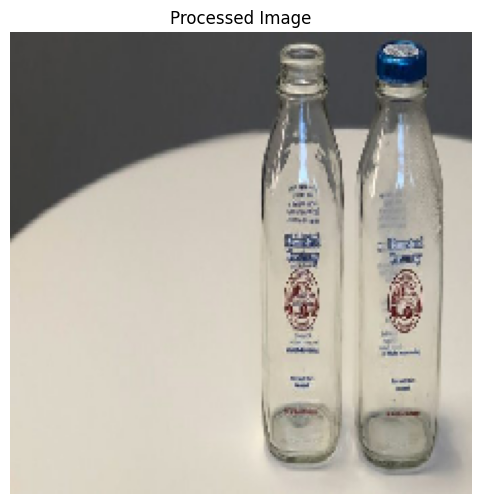

In [55]:
# Remove the batch dimension (assuming the batch size is 1)
processed_image_for_display = np.squeeze(processed_image)

# Display the processed image
plt.figure(figsize=(6, 6))
plt.imshow((processed_image_for_display + 1) / 2)  # Rescale if preprocess_input scales to [-1, 1]
plt.title("Processed Image")
plt.axis('off')
plt.show()

In [56]:
prediction = model.predict(processed_image)

1/1 [==============================] - 0s 37ms/step


In [57]:
# Assuming you have a list of class names
class_names = ['AluCan', 'Glass', 'HDPEM', 'PET']

# Get the index of the highest probability
predicted_index = np.argmax(prediction[0])

# Get the name of the predicted class
predicted_class = class_names[predicted_index]

print(f"Predicted class: {predicted_class}")

Predicted class: Glass


In [53]:
prediction

array([[0.01333706, 0.9104363 , 0.01394696, 0.06227968]], dtype=float32)

In [31]:
model.save('pet_hdpe_can_glass_model.h5')


/home/jovyan/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
